## Udacity Machine Learning Nanodegree Capstone Project
### Capital Bikeshare Demand Prediction



### Getting Started
This project focuses on predicting the number of bike rentals every hour for the Capital Bikeshare program, as part of a Kaggle competition. It aims to understand key factors driving the hourly bikeshare demand using historical bikeshare usage data with weather data. 

The dataset for this project comes from Kaggle, in which hourly rental data spanning two years (2011-2012) for the Capital Bikeshare program is collected. The training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. 

Date fields include:
-  datetime - hourly date + timestamp 
-  season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
-  holiday - whether the day is considered a holiday (binary indicator)
-  workingday - whether the day is neither a weekend nor holiday (binary indicator)
-  weather – four categories include:
> 1. Clear, Few clouds, Partly cloudy, Partly cloudy 
> 2. Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
> 3. Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
> 4. Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
-  temp - temperature in Celsius
-  atemp - "feels like" temperature in Celsius
-  humidity - relative humidity
-  windspeed - wind speed
-  casual - number of non-registered user rentals initiated (dependent variable)
-  registered - number of registered user rentals initiated (dependent variable)
-  count - number of total rentals 

Target variables are: casual, registered and count.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import pylab
import calendar
import seaborn as sn
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline

# Load the dataset
train = pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
    
# Success
print("Bikeshare dataset has {} data points with {} variables each.".format(*train.shape))

# Show data types for all variables and take a quick look at the data, no null data.
train.info()
test.info()

print(train.head())


Bikeshare dataset has 10886 data points with 12 variables each.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null object
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non

### Data Exploration

#### Distribution of target variables
The distribution charts below indicate a right skewed frequency distribution of all three target variables. For a right skewed distribution, the mean is greater than the median. The tail of the distribution on the right hand side is much longer than on the left hand side.¶

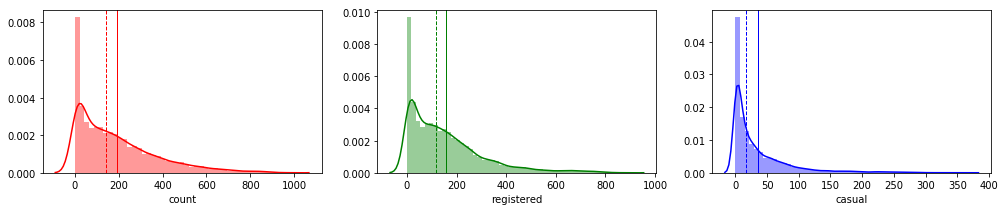

In [2]:
# distribution of target variables
# sn.distplot(train['count'],color="r")
clr = ['red', 'green', 'blue']
fig, axs = plt.subplots(ncols=3,figsize=(17,3))

for i, var in enumerate(['count', 'registered', 'casual']):
    plt.subplot(131 + i)
    sn.distplot(train[var],  color = clr[i])
    plt.axvline(train[var].mean(), color=clr[i], linestyle='solid', linewidth=1)
    plt.axvline(train[var].median(), color=clr[i], linestyle='dashed', linewidth=1)
    
# The distribution of target variables is not normal distribution. A lot of zeros.


#### Log transformation of target variables
With such a heavily right skewed data, it is a common practice to apply a logarithmic transformation on the data so that very large and very small values do not negatively affect the performance of a learning algorithm. When applying this transformation, it has to note that the logarithm of 0 is undefined, so the values need to be translated by a small amount above 0 to apply the logarithm successfully. Here, 1 is added to avoid error created by log transformation.

Run the code cell below to perform a log transformation on the target variables and visualize the results (Chart Q2-6). After the log transformation, they look closer to a normal distribution. Its mean (solid line) is slightly smaller than its median (dashed line). 

In [3]:
# log transformation of target variables (skewed)
# For target variables with zero values: add 1 to avoid error created by log transformation.
for col in ['casual', 'registered', 'count']:
    train['%s_log' % col] = np.log(train[col] + 1)

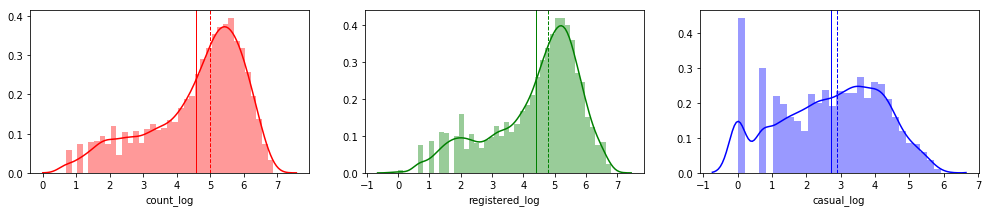

In [4]:
#distribution of target variables after log tarnsformation.
clr = ['red', 'green', 'blue']
fig, axs = plt.subplots(ncols=3,figsize=(17,3))

for i, var in enumerate(['count_log', 'registered_log', 'casual_log']):
    plt.subplot(131 + i)
    sn.distplot(train[var],  color = clr[i])
    plt.axvline(train[var].mean(), color=clr[i], linestyle='solid', linewidth=1)
    plt.axvline(train[var].median(), color=clr[i], linestyle='dashed', linewidth=1)

#### Combine train and test data

In [5]:
#combine train and test data
fulldata = pd.concat((train, test)).reset_index(drop=True)

dt = pd.DatetimeIndex(fulldata['datetime'])
fulldata.set_index(dt, inplace=True, drop=False)

In [6]:
fulldata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 15 columns):
atemp             17379 non-null float64
casual            10886 non-null float64
casual_log        10886 non-null float64
count             10886 non-null float64
count_log         10886 non-null float64
datetime          17379 non-null object
holiday           17379 non-null int64
humidity          17379 non-null int64
registered        10886 non-null float64
registered_log    10886 non-null float64
season            17379 non-null int64
temp              17379 non-null float64
weather           17379 non-null int64
windspeed         17379 non-null float64
workingday        17379 non-null int64
dtypes: float64(9), int64(5), object(1)
memory usage: 2.1+ MB


#### Take a quick look at the relationship between target variables and weather, season, etc.

#### First, average hourly bike share demand by season. Biking appears to be more popular during the summer and fall. (season - 1 = spring, 2 = summer, 3 = fall, 4 = winter)

Text(0.5,1,'Average hourly bikeshare demand (all users) by season')

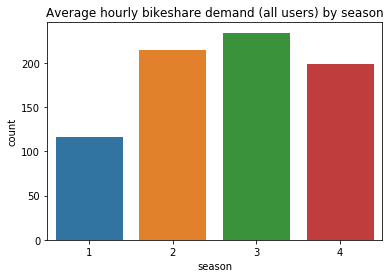

In [7]:
group_season = train.groupby(['season'])['count'].mean().reset_index()
ax = sn.barplot(x = group_season['season'], y = group_season['count'])
ax.set(xlabel='season', ylabel='count')
plt.title('Average hourly bikeshare demand (all users) by season')

#### Second, average hourly bikeshare demand by weather (weather=1, Clear, Few clouds, Partly cloudy, Partly cloudy; 2=Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist, 3=Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds, 4=Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog)

#### Bike usage is negatively affected by cold weather, precipitation (rain and snow).

Text(0.5,1,'Average hourly bikeshare demand (all users) by weather')

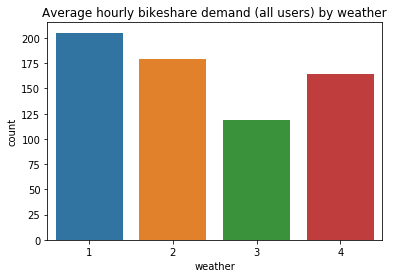

In [8]:
group_weather = train.groupby(['weather'])['count'].mean().reset_index()
ax = sn.barplot(x = group_weather['weather'], y = group_weather['count'])
ax.set(xlabel='weather', ylabel='count')
plt.title('Average hourly bikeshare demand (all users) by weather')

#### Also, we look at the relationship between weather variables vs. count. The scatter plots show that total bikeshare demand is positively related to temperature, feels like temperature. It is also negatively related to humidity. Windspeed does not have a normal distribution and it has many zero values. Windspeed and bikeshare demand may not have a linear relationship.¶

Text(0.5,1,'Pairwise relationship between total bikeshare demand (count) and temp, atemp, humidity, windspeed')

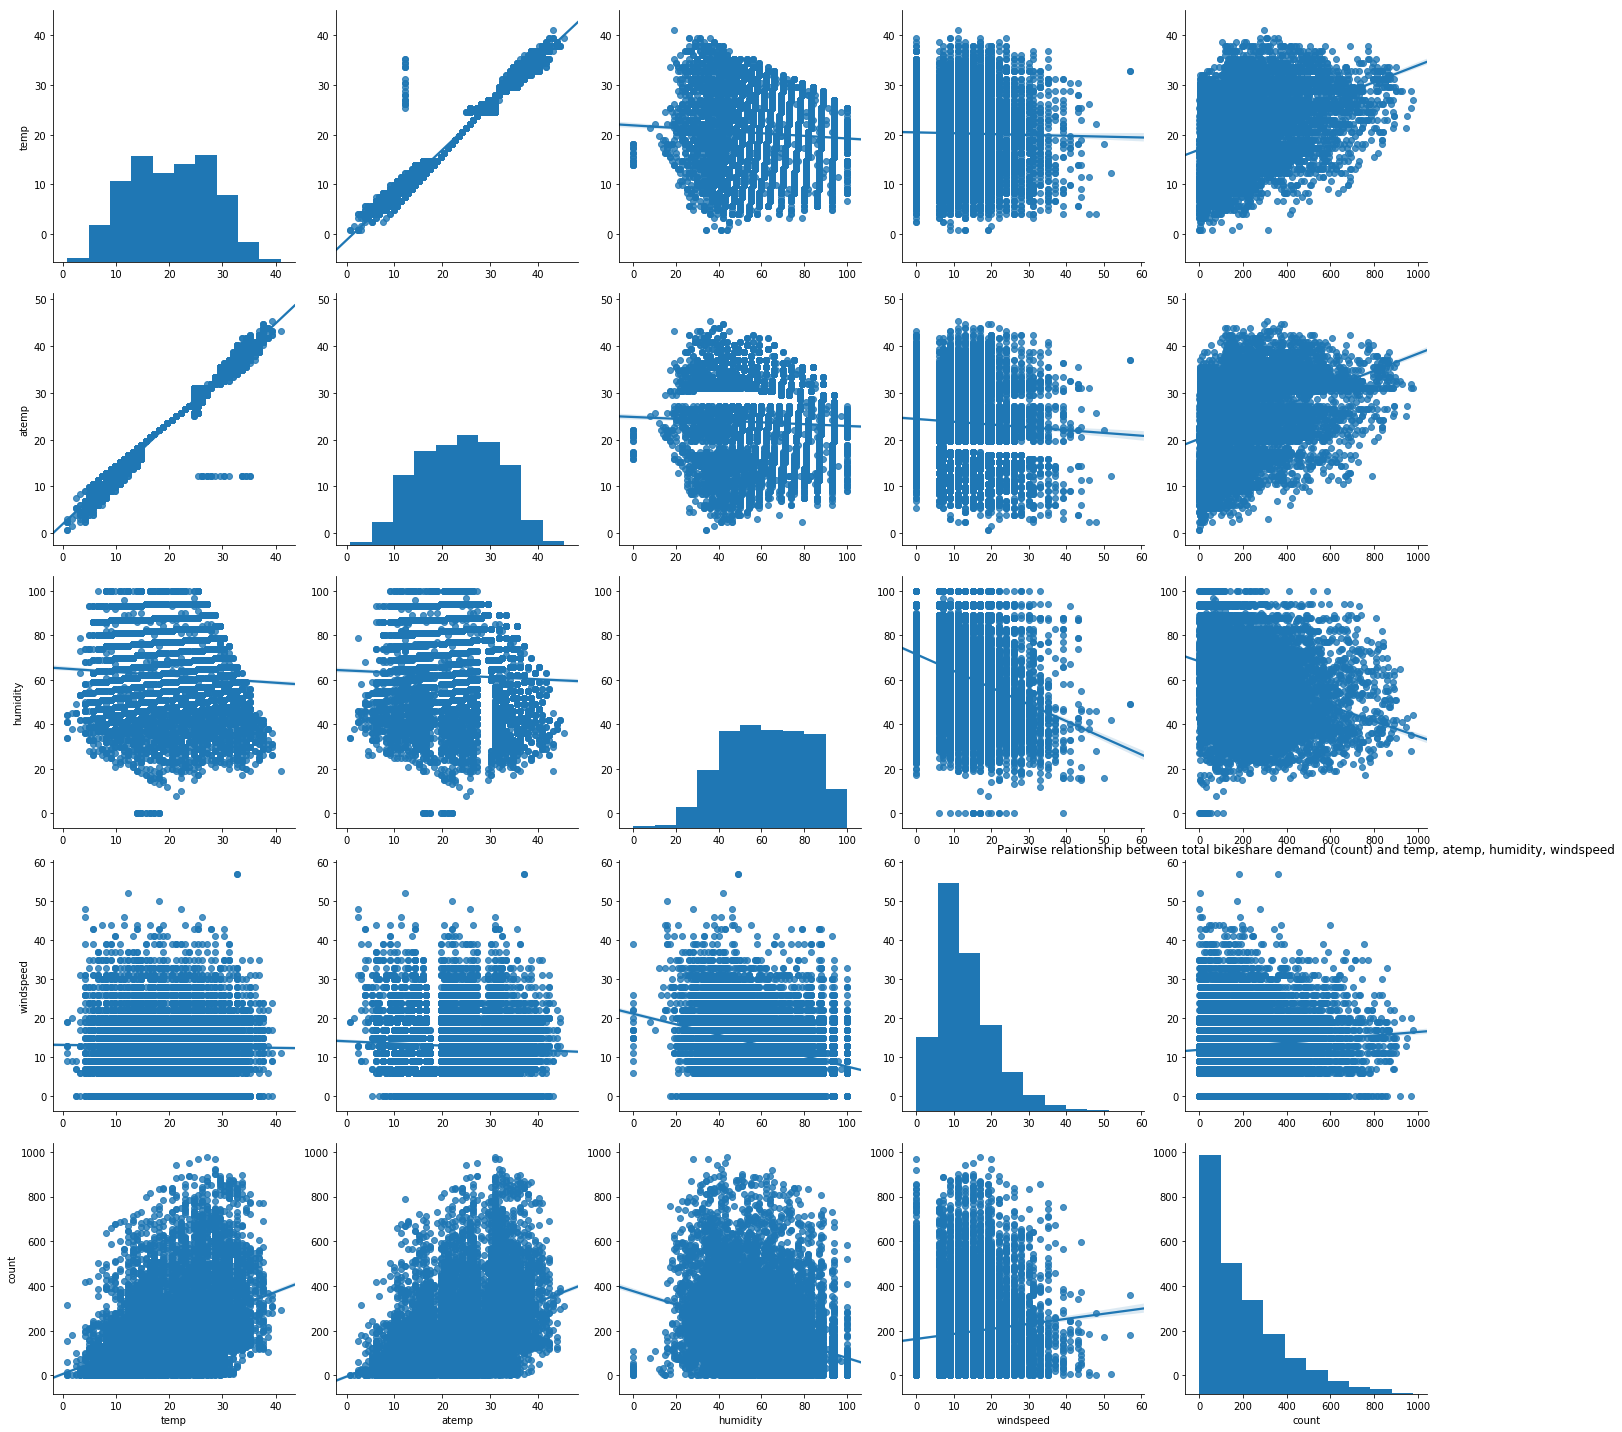

In [9]:
weather=train[['temp','atemp', 'humidity', 'windspeed','count']]
# Plot pairwise relationships 
g = sn.pairplot(weather, kind="reg", size=4)
plt.title('Pairwise relationship between total bikeshare demand (count) and temp, atemp, humidity, windspeed')

#### Third, average hourly bikeshare demand (counts): holiday vs. non-holiday. Average hourly total demand in non-holidays are slightly higher than it is in holidays. However, looking at casual users only, it is clear that the holidays have a much stronger demand from casual users.

Text(0.5,1,'Average hourly bikeshare demand (all users): holiday vs. non-holiday')

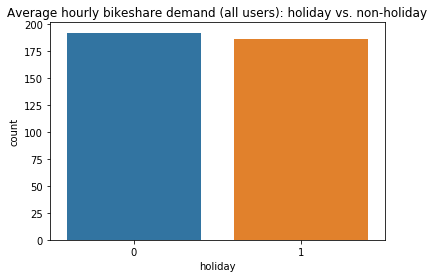

In [10]:
group_hol = train.groupby(['holiday'])['count'].mean().reset_index()
ax = sn.barplot(x = group_hol['holiday'], y = group_hol['count'])
ax.set(xlabel='holiday', ylabel='count')
plt.title('Average hourly bikeshare demand (all users): holiday vs. non-holiday')

Text(0.5,1,'Average hourly bikeshare demand (casual users): holiday vs. non-holiday')

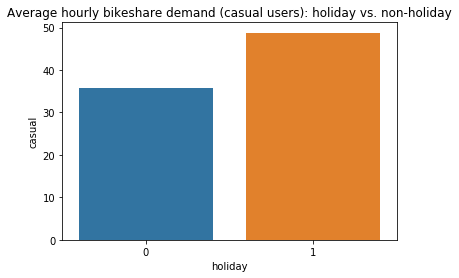

In [11]:
group_hol = train.groupby(['holiday'])['casual'].mean().reset_index()
ax = sn.barplot(x = group_hol['holiday'], y = group_hol['casual'])
ax.set(xlabel='holiday', ylabel='casual')
plt.title('Average hourly bikeshare demand (casual users): holiday vs. non-holiday')

#### Fourth, average hourly bikeshare demand (all users): working days vs. non-working days. Average hourly total demand in working days are slightly higher than it is in working days. However, looking at registered users only, it is clear that the working days have a much stronger demand from registered users.

Text(0.5,1,'Average hourly bikeshare demand (all users): working day vs. non-working days')

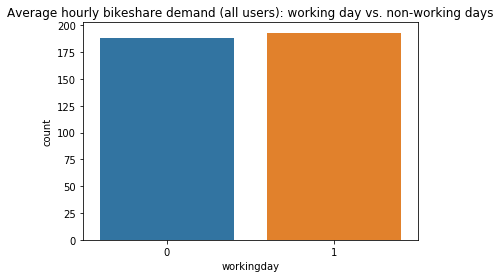

In [12]:
group_work = train.groupby(['workingday'])['count'].mean().reset_index()
ax = sn.barplot(x = group_work['workingday'], y = group_work['count'])
ax.set(xlabel='workingday', ylabel='count')
plt.title('Average hourly bikeshare demand (all users): working day vs. non-working days')

Text(0.5,1,'Average hourly bikeshare demand (registered users): working day vs. non-working days')

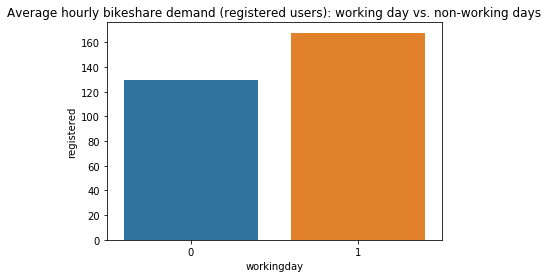

In [13]:
group_work = train.groupby(['workingday'])['registered'].mean().reset_index()
ax = sn.barplot(x = group_work['workingday'], y = group_work['registered'])
ax.set(xlabel='workingday', ylabel='registered')
plt.title('Average hourly bikeshare demand (registered users): working day vs. non-working days')

#### Zeros in weather data
Count number of zeros in each weather related column. Columns of atemp, humidity and windspeed, especially windspeed show zeros. The possible explanations: (1) they are indeed zeros at that hour; (2) they are too low to be measured, therefore leaving as 0; (3) zero means not available.

Windspeed does not sound a major factor to explain bike share use. Unless there is a windstorm, people usually cannot tell the difference between a windspeed of 5 miles per hour and 10 miles per hour, therefore won't take this factor into account when choosing bike share use.

As for now, no adjustment will be made on these weather variables.

In [14]:
zeroweather = fulldata[['atemp','humidity','season','temp','windspeed','weather','workingday']].groupby('workingday').agg(lambda x: x.eq(0).sum())
print (zeroweather)

            atemp  humidity  season  temp  windspeed  weather
workingday                                                   
0             2.0         0       0   0.0      663.0        0
1             0.0        22       0   0.0     1517.0        0


#### Create new features from "datetime".

The following new features are created. Most of them aim at control for seasonality effects. The reason to create such a feature is also briefly discussed.
- Date: It is expected to see that daily bike share demand is very different, depending on major events around the city (festival, parade, conferences), weather (especially there are major weather events such as winterstorm, flood, windstorm, etc.), competitive transport modes' service condition (major meltdown of metrorail system, shutdown of a bus line, major incidents on highway).
- Hour: Traffic demand by hour in a day obviously is very different. There are typically two peak periods (AM and PM rush hours) in a day with a high traffic demand. Even AM and PM peak periods would show a different demand pattern. In the morning, most people usually have one single destination in mind: getting to work or school. In the evening, people leave work at different times, and run errands here and there (restaurant, grocery store, entertainment, etc.) that create more stop-making during the evening. These additional stops create many shorter than usual trips, which sound a good candidate for bike share trip.
- Day: Day will work similar as Date.
- Month: Bike share demand, like all other travel demand, has a clear monthly/seasonal fluctuation.  
- Year: Annual demand seems to grow in these two years.
- Day of week: It further helps to specify the difference between weekday and weekend. It is also widely accepted that Monday/Friday would show a different pattern compared to Tue.-Thu. The variation in daily demand can be explained by weekly cycle.
- Week of year: Week of year will work similar as Month/Season.

#### Day Effect:
Note that in general we have to create k-1 dummy variables if we want to analyze the effect of a categorical variable with k classes in a linear regression model. Since there are 7 days in a week, the first 6 days are each represented by one of the dummies, each to one for the days they represent, and zero elsewhere. The reference day is Sunday, so for all counts that are collected on a Sunday, the corresponding six dummies are coded zero.



In [15]:
#Create new features from "Datetime" variable.
#date
#fulldata["date"] = fulldata.datetime.apply(lambda x : x.split()[0])
#hour - 00 to 24
#fulldata["hour"] = fulldata.datetime.apply(lambda x : x.split()[1].split(":")[0])
#day of week - Monday through Sunday
#fulldata["dayofweek"] = fulldata.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
#month - Jan to Dec
#fulldata["month"] = fulldata.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
#season
fulldata['season'] = fulldata.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
#weather
fulldata['weather'] = fulldata.weather.map({1: " Clearcloudy",\
                                        2 : " MistCloudy", \
                                        3 : " LightSnowRain", \
                                        4 :" HeavySnowRain" })

In [16]:
fulldata['year'] = dt.year
fulldata['date'] = dt.date
fulldata['day'] = dt.day
fulldata['month'] = dt.month
fulldata['hour'] = dt.hour
fulldata['dayofweek'] = dt.dayofweek
fulldata['weekofyr'] = dt.weekofyear


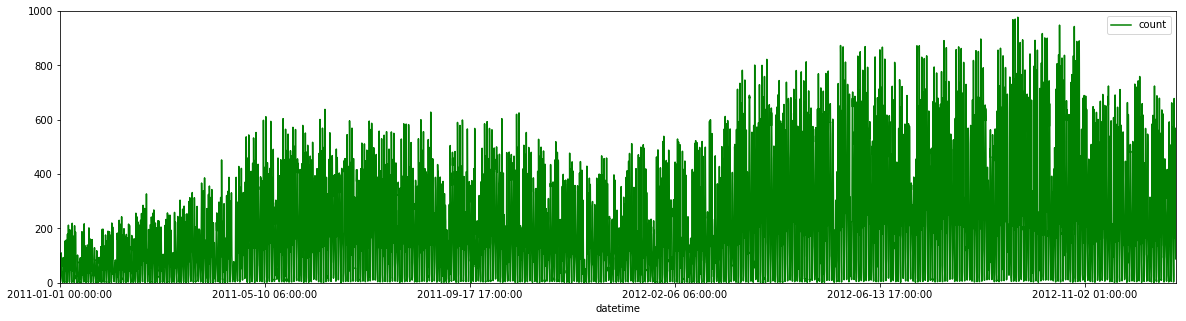

In [17]:
#Bike share demand over time - total count
timeseries = train.set_index('datetime')
timeseries['count'].plot(figsize=(20,5),ylim=(0, 1000),legend='true',color='green')

In [18]:
#get a better idea about daily bike share demand - distribution, best and worst days
dailytotal=fulldata.groupby(['date'],as_index=False)['count'].agg(sum)
dailytotal.columns = [ 'date', 'dailycount']
dailytotal.head()
#print (dailytotal.nlargest(10, 'dailycount'))
#fulldata.date.nunique()

,date,dailycount
0,2011-01-01,985.0
1,2011-01-02,801.0
2,2011-01-03,1349.0
3,2011-01-04,1562.0
4,2011-01-05,1600.0


####  As mentioned earlier, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. That is, training set should expect to include 19*12*2=456 records for daily total count. There are 456 records in dailycount dataframe. In other words, there is no missing data for total count in training set.

In [19]:
# Not everyday reports a total of 24 hours' data. Some hours are missing.
dailyhr=fulldata.groupby(['date'],as_index=False)['hour'].agg('count')
dailyhr.columns = [ 'date', 'hour']
dailyhr.head(20)

,date,hour
0,2011-01-01,24
1,2011-01-02,23
2,2011-01-03,22
3,2011-01-04,23
4,2011-01-05,23
5,2011-01-06,23
6,2011-01-07,23
7,2011-01-08,24
8,2011-01-09,24
9,2011-01-10,24


In [20]:
display(dailytotal.describe())

,dailycount
count,456.000000
mean,4573.412281
std,1868.740135
min,605.000000
25%,3305.500000
50%,4585.500000
75%,5987.500000
max,8714.000000


In [21]:
print (dailytotal.nlargest(10, 'dailycount'))

           date  dailycount
623  2012-09-15      8714.0
504  2012-05-19      8294.0
617  2012-09-09      8227.0
643  2012-10-05      8156.0
518  2012-06-02      8120.0
622  2012-09-14      8009.0
644  2012-10-06      7965.0
620  2012-09-12      7870.0
595  2012-08-18      7865.0
441  2012-03-17      7836.0


In [22]:
print (dailytotal.nsmallest(10, 'dailycount'))

           date  dailycount
64   2011-03-06       605.0
68   2011-03-10       623.0
17   2011-01-18       683.0
340  2011-12-07       705.0
105  2011-04-16       795.0
1    2011-01-02       801.0
8    2011-01-09       822.0
7    2011-01-08       959.0
0    2011-01-01       985.0
16   2011-01-17      1000.0


#### 2012 is a leap year. There are total 731 days in 2011 and 2012.

In [23]:
fulldata.date.nunique()

731

#### Dates that are coded as holiday in the dataset are listed below. Holiday includes: 
2011 - MLK (Mon), Presidents' Day (Mon), Tax Day (Fri), Memorial Day (Mon), July 4 (Mon), Labor Day (Mon), Columbus Day (Mon), Veterans' Day (Fri), Thanksgiving (Thu), and Christmas (observed, Mon). 

2012 - New Year's Day (observed, Mon), MLK (Mon), Presidents' Day (Mon), Tax Day (Mon), Memorial Day(Mon), July 4 (Wed), Labor Day (Mon), Columbus Day (Mon), Veterans' Day (observed, Mon), Thanksgiving (Thu), and Christmas (Tue). 

#### New Year's Day is missing in 2011? New Year's Day 2011 is observed on Dec 31, 2010 (Fri). 1/1/2011 is a Saturday.

In [24]:
holiday=fulldata.loc[fulldata['holiday'] == 1]
holiday_ttl=holiday.groupby(['date'],as_index=False)['count','workingday','holiday'].agg(sum)
holiday_ttl.columns = [ 'date', 'dailycount','workingday','holiday']
holiday_ttl.head(30)

,date,dailycount,workingday,holiday
0,2011-01-17,1000.0,0,24
1,2011-02-21,NaN,0,24
2,2011-04-15,3126.0,0,24
3,2011-05-30,NaN,0,24
4,2011-07-04,6043.0,0,24
5,2011-09-05,3351.0,0,24
6,2011-10-10,5117.0,0,24
7,2011-11-11,3368.0,0,24
8,2011-11-24,NaN,0,24
9,2011-12-26,NaN,0,23


#### Is bike share demand low on Tax Day? After pulling out all April data, the answer is no. Though it is counted as a holiday, its bike share demand remains at a regular working day's level. Tax Day therefore needs to be re-coded as a regular working day, not holiday.


In [25]:
dailytotal.loc[dailytotal['date']=='2011-04-15']
dailytotal.iloc[90:110]

,date,dailycount
90,2011-04-01,2227.0
91,2011-04-02,2252.0
92,2011-04-03,3249.0
93,2011-04-04,3115.0
94,2011-04-05,1795.0
95,2011-04-06,2808.0
96,2011-04-07,3141.0
97,2011-04-08,1471.0
98,2011-04-09,2455.0
99,2011-04-10,2895.0


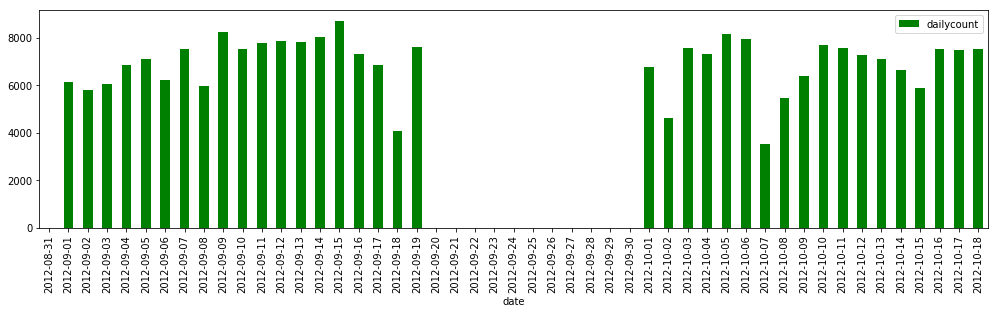

In [26]:
holiday_impact_example=dailytotal.iloc[608:657]
holiday_impact_example.plot(x='date',kind='bar',figsize=(17,4),color='green')

#### How about some non-holidays such as Black Friday, Christmas Eve, New Year's Eve, or just 1 day before or after a Federal Holiday? They are not holidays but they typically have some lead and lag effects.

#### We took two months' data out and visualize the daily total demand between September and October 2012. Sep. 3 is Labor Day, and Oct. 8 is Columbus Day. Notice that calendar anomalies are not only observed on holiday day, but also on days before/after holiday. 

#### We will add a new feature -holiday_impact (a dummy variable) to model the holiday impact- for all Federal holidays listed above (exclude Tax Day), as well as adjacent weekdays/weekend for all these holidays, holiday_impact=1, otherwise=0. 
- Most holidays fall on a Monday, the Tuesday immediately after it would be considered as a holiday_impact=1. The Saturday and Sunday immediately before it would also be considered as a holiday_impact=1. 
- For holiday occuring on a Tuesday, the Monday and weekend before, and the Wednesday after are defined as a holiday_impact=1.
- For holiday occuring on a Wednesday, the Tuesday before and Thursday after are defined as a holiday_impact=1.
- For holiday occuring on a Thursday, the Wednesday before, and the Friday and weekend after are defined as a holiday_impact=1. 
- For holiday occuring on a Friday, the Thursday before and weekend after are defined as a holiday_impact=1.

- Tax Day will be re-coded as a working day.

#### Therefore, the following dates will be coded as holiday_impact=1.
- 2011: 2011-01-15; 2011-01-16; 2011-01-17; 2011-01-18; 2011-02-19; 2011-02-20; 2011-02-21; 2011-02-22; 2011-05-28; 2011-05-29; 2011-05-30; 2011-05-31; 2011-07-02; 2011-07-03; 2011-07-04; 2011-07-05; 2011-09-03; 2011-09-04; 2011-09-05; 2011-09-06; 2011-10-08; 2011-10-09; 2011-10-10; 2011-10-11; 2011-11-10; 2011-11-11; 2011-11-12; 2011-11-13; 2011-11-23; 2011-11-24; 2011-11-25; 2011-11-26; 2011-11-27; 2011-12-24; 2011-12-25; 2011-12-26; 2011-12-27; 2011-01-02; 2011-01-01;
- 2012: 2011-12-31; 2012-01-01; 2012-01-02; 2012-01-03; 2012-01-14; 2012-01-15; 2012-01-16; 2012-01-17; 2012-02-18; 2012-02-19; 2012-02-20; 2012-02-21; 2012-05-26; 2012-05-27; 2012-05-28; 2012-07-03; 2012-07-04; 2012-07-05; 2012-09-01; 2012-09-02; 2012-09-03; 2012-09-04; 2012-10-06; 2012-10-07; 2012-10-08; 2012-10-09; 2012-11-10; 2012-11-11; 2012-11-12; 2012-11-13; 2012-11-21; 2012-11-22; 2012-11-23; 2012-11-24; 2012-11-25; 2012-12-22; 2012-12-23; 2012-12-24; 2012-12-25; 2012-12-26.	

In [27]:
holiday_impact_days=['2011-01-15', '2011-01-16', '2011-01-17', '2011-01-18', '2011-02-19', '2011-02-20', '2011-02-21', 
                    '2011-02-22', '2011-05-28', '2011-05-29', '2011-05-30', '2011-05-31', '2011-07-02', '2011-07-03', 
                    '2011-07-04', '2011-07-05', '2011-09-03', '2011-09-04', '2011-09-05', '2011-09-06', '2011-10-08', 
                    '2011-10-09', '2011-10-10', '2011-10-11', '2011-11-10', '2011-11-11', '2011-11-12', '2011-11-13', 
                    '2011-11-23', '2011-11-24', '2011-11-25', '2011-11-26', '2011-11-27', '2011-12-24', '2011-12-25', 
                    '2011-12-26', '2011-12-27', '2011-01-02', '2011-01-01', '2011-12-31', '2012-01-01', '2012-01-02', 
                    '2012-01-03', '2012-01-14', '2012-01-15', '2012-01-16', '2012-01-17', '2012-02-18', '2012-02-19', 
                    '2012-02-20', '2012-02-21', '2012-05-26', '2012-05-27', '2012-05-28', '2012-07-03', '2012-07-04', 
                    '2012-07-05', '2012-09-01', '2012-09-02', '2012-09-03', '2012-09-04', '2012-10-06', '2012-10-07', 
                    '2012-10-08', '2012-10-09', '2012-11-10', '2012-11-11', '2012-11-12', '2012-11-13', '2012-11-21', 
                    '2012-11-22', '2012-11-23', '2012-11-24', '2012-11-25', '2012-12-22', '2012-12-23', '2012-12-24', 
                    '2012-12-25', '2012-12-26']

In [28]:
fulldata['holiday_impact'] = fulldata.index.get_level_values(0).isin(holiday_impact_days).astype(int)

#### How about those days that Federal government was closed or has late opening/early closing? I searched the website of OPM and got the record for 2011 and 2012. https://www.opm.gov/policy-data-oversight/snow-dismissal-procedures/status-archives/#year2011 Here are some days with special events that might have a significant impact on bike share demand in the DC area.

- 1/18/2011: Federal government delayed arrival due to winterstorm
- 1/26/2011: Federal government early departure due to the Carmageddon Snowstorm
- 1/27/2011: Federal government delayed arrival due to the Carmageddon Snowstorm
##### A snowstorm raced toward Washington from southwest to northeast on Wednesday, January 26, 2011. Heavy thundersleet and thundersnow overtook the region during the mid-afternoon. Federal workers were released two hours early, causing an early uptick in traffic volumes, coincident with the heaviest snowfall. Commuters reported sitting in traffic for over six hours. Some drivers were stranded on the George Washington Parkway into the early morning hours.
- 8/23/2011: Federal government early dismissal due to the M5.8 Earthquake
##### The White House, the Capitol, and various other buildings were evacuated. The afternoon traffic rush hour was affected, with some traffic lights inoperative, and the Washington Metro system's trains operated at reduced speeds while tracks and tunnels were inspected. District of Columbia Public Schools were shut down the day after while inspections of the schools were conducted.
- 1/23/2012: Federal government delayed arrival due to winterstorm
- 10/29/2012: Federal government closed due to hurricane Sandy
- 10/30/2012: Federal government closed due to hurricane Sandy
##### The effects of Hurricane Sandy in Maryland and Washington, D.C. included tropical storm force sustained winds with isolated gusts to hurricane force, plus significant mountain snow and coastal flooding. On October 26, Washington, D.C. Mayor Vincent Gray declared a state of emergency.That same day the governors of Pennsylvania, Maryland, and Virginia also declared states of emergency in preparation of the approaching storm. The United States Office of Personnel Management announced federal offices in the Washington, D.C. area would be closed to the public on October 29–30. In addition, Washington, D.C., Metro service, both rail and bus, was canceled on October 29 due to expected high winds, the likelihood of widespread power outages, and the closing of the federal government. President Obama declared a state of emergency for the District of Columbia. The Smithsonian Institution closed for the day of October 29. 

Sources: 
- https://www.opm.gov/policy-data-oversight/snow-dismissal-procedures/status-archives/#year2011
- https://en.wikipedia.org/wiki/Effects_of_Hurricane_Sandy_in_Maryland_and_Washington,_D.C.
- https://en.wikipedia.org/wiki/2011_Virginia_earthquake
- https://wtop.com/weather-news/2015/01/history-disastrous-snow-storms-d-c-area/

#### Most of these days are in the test set. It may be worth a try to adjust working day definition - to exclude these federal gov close days from working day=1.

In [100]:
#create a new feature - federalgov - if OPM status changed to close or late opening or early dismissal due to weather or other events.
#federal_gov_close=['2011-01-18','2011-01-26','2011-01-27','2011-08-23','2012-01-23','2012-10-29','2012-10-30']
#fulldata['federalgov'] = fulldata.index.get_level_values(0).isin(federal_gov_close).astype(int)
# Only 1 day in train data is coded as federal_gov_close=1.
# It is better to combine this feature with working day feature.

In [197]:
#dt1 = pd.DatetimeIndex(fulldata['date'])
#fulldata.set_index(dt1, inplace=True, drop=False)

In [29]:
fede=fulldata[['datetime','date']]

dt1 = pd.DatetimeIndex(fede['date'])
fede.set_index(dt1, inplace=True, drop=False)

In [30]:
federal_gov_close=['2011-01-18','2011-01-26','2011-01-27','2011-08-23','2012-01-23','2012-10-29','2012-10-30']
fede['federalgov'] = fede.index.get_level_values(0).isin(federal_gov_close).astype(int)

C:\Users\E015919\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [31]:
feder = fede.groupby('federalgov')['date'].nunique()
print (feder)

federalgov
0    724
1      7
Name: date, dtype: int64


In [32]:
fulldata1=pd.merge(fulldata, fede, left_on='datetime',right_on='datetime')

In [33]:
fulldata1.head()

,atemp,casual,casual_log,count,count_log,datetime,holiday,humidity,registered,registered_log,...,year,date_x,day,month,hour,dayofweek,weekofyr,holiday_impact,date_y,federalgov
0,14.395,3.0,1.386294,16.0,2.833213,2011-01-01 00:00:00,0,81,13.0,2.639057,...,2011,2011-01-01,1,1,0,5,52,1,2011-01-01,0
1,13.635,8.0,2.197225,40.0,3.713572,2011-01-01 01:00:00,0,80,32.0,3.496508,...,2011,2011-01-01,1,1,1,5,52,0,2011-01-01,0
2,13.635,5.0,1.791759,32.0,3.496508,2011-01-01 02:00:00,0,80,27.0,3.332205,...,2011,2011-01-01,1,1,2,5,52,0,2011-01-01,0
3,14.395,3.0,1.386294,13.0,2.639057,2011-01-01 03:00:00,0,75,10.0,2.397895,...,2011,2011-01-01,1,1,3,5,52,0,2011-01-01,0
4,14.395,0.0,0.000000,1.0,0.693147,2011-01-01 04:00:00,0,75,1.0,0.693147,...,2011,2011-01-01,1,1,4,5,52,0,2011-01-01,0


In [34]:
fed = fulldata1.groupby('federalgov')['date_y'].nunique()
print (fed)

#seems need to keep federalgov_y, date_y,drop federalgov_x, date_x.

federalgov
0    724
1      7
Name: date_y, dtype: int64


In [40]:
#when trying create a federalgov column in fulldata (see the code below), it only captures 4 days, not 7 days in federal_gov_close.
#federal_gov_close=['2011-01-18','2011-01-26','2011-01-27','2011-08-23','2012-01-23','2012-10-29','2012-10-30']
#fulldata[fulldata.index.isin(federal_gov_close)]

#fulldata['federalgov'] = fulldata.index.get_level_values(0).isin(federal_gov_close).astype(int)
#so I create a new dataframe to re-index it based on date, not datetime, and then merge it back to fulldata.


In [35]:
worki = fulldata1.groupby('workingday')['date_y'].nunique()
print (worki)

workingday
0    231
1    500
Name: date_y, dtype: int64


In [36]:
fulldata1.loc[fulldata1['federalgov'] ==1, 'workingday'] = 0

In [37]:
worki1 = fulldata1.groupby('workingday')['date_y'].nunique()
print (worki1)

workingday
0    238
1    493
Name: date_y, dtype: int64


In [38]:
dt1 = pd.DatetimeIndex(fulldata1['datetime'])
fulldata1.set_index(dt1, inplace=True, drop=False)

In [39]:
def get_day(day_start):
    day_end = day_start + pd.offsets.DateOffset(hours=23)
    return pd.date_range(day_start, day_end, freq="H")

# tax day now coded as a workingday=1.
fulldata1.loc[get_day(pd.datetime(2011, 4, 15)), "workingday"] = 1
fulldata1.loc[get_day(pd.datetime(2012, 4, 16)), "workingday"] = 1

#fulldata.loc[get_day(pd.datetime(2011, 1, 18)), "workingday"] = 0
#fulldata.loc[get_day(pd.datetime(2011, 1, 26)), "workingday"] = 0
#fulldata.loc[get_day(pd.datetime(2011, 1, 27)), "workingday"] = 0
#fulldata.loc[get_day(pd.datetime(2011, 8, 23)), "workingday"] = 0
#fulldata.loc[get_day(pd.datetime(2012, 1, 23)), "workingday"] = 0
#fulldata.loc[get_day(pd.datetime(2012, 10, 29)), "workingday"] = 0
#fulldata.loc[get_day(pd.datetime(2012, 10, 30)), "workingday"] = 0

In [40]:
worki1 = fulldata1.groupby('workingday')['date_y'].nunique()
print (worki1)

workingday
0    236
1    495
Name: date_y, dtype: int64


#### Cherry Blossom Festival
https://www.capitalbikeshare.com/attractions/cherry-blossoms

The annual bloom of the cherry trees along the Potomac River is a sure sign that spring has arrived in the nation’s capital.

For two weeks in late March and early April, millions of visitors come to metro DC to take in the blossoms as they decorate some of our most famous national landmarks.

The enduring attraction of the cherry trees and the National Cherry Blossom Festival make the bloom period a great time to get around by bike. Pick up a bike from a nearby station and ride among the blossoms at Hains Point. Then stop and take in the majesty of the monuments shrouded in blooms.

#### We therefore create a feature - cherry =1 if dates fall into the Cherry Blossom Festival.
- 2011 National Cherry Blossom Festival: 3/26/2011 - 4/10/2011
- 2012 National Cherry Blossom Festival: 3/20/2012 - 4/27/2012

In [41]:
#create a new feature - cherry - if dates are during National Cherry Blossom Festival
cherry_festival=['2011-03-26','2011-03-27','2011-03-28','2011-03-29','2011-03-30','2011-03-31','2011-04-01','2011-04-02',
                 '2011-04-03','2011-04-04','2011-04-05','2011-04-06','2011-04-07','2011-04-08','2011-04-09','2011-04-10',
                 '2012-03-20','2012-03-21','2012-03-22','2012-03-23','2012-03-24','2012-03-25','2012-03-26','2012-03-27',
                 '2012-03-28','2012-03-29','2012-03-30','2012-03-31','2012-04-01','2012-04-01','2012-04-01','2012-04-02',
                 '2012-04-03','2012-04-04','2012-04-05','2012-04-06','2012-04-07','2012-04-08','2012-04-09','2012-04-10',
                 '2012-04-11','2012-04-12','2012-04-13','2012-04-14','2012-04-15','2012-04-16','2012-04-17','2012-04-18',
                 '2012-04-19','2012-04-20']
fulldata1['cherry'] = fulldata1.index.get_level_values(0).isin(cherry_festival).astype(int)

In [57]:
# Bike share demand over time - registered and casual
#timeseries['registered'].plot(figsize=(20,5),ylim=(0, 1000),color='blue',legend='true')
#timeseries['casual'].plot(figsize=(20,5),ylim=(0, 1000),color='orange',legend='true')
#Charts tell that bike demand shows an upward trend, with a seasonal fluctuations. Registered users dominated the demand.
# not fill the gaps for timeseries. decided not use timeseries.

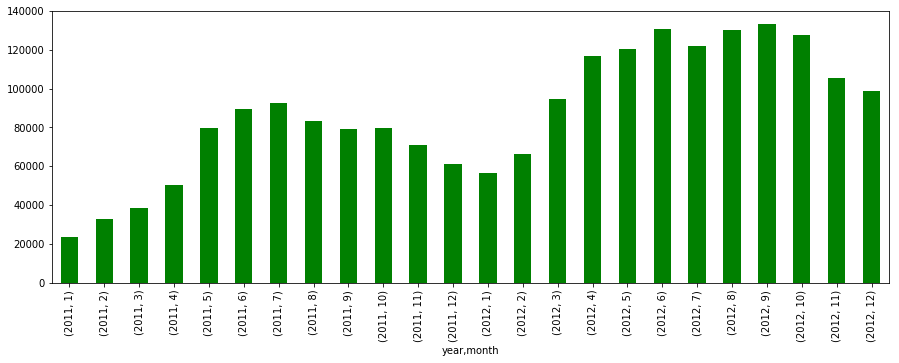

In [42]:
#Bike share demand over month - casual
fulldata1.groupby(['year', 'month'])['count'].agg(sum).plot(kind='bar',figsize=(15,5),color='green')

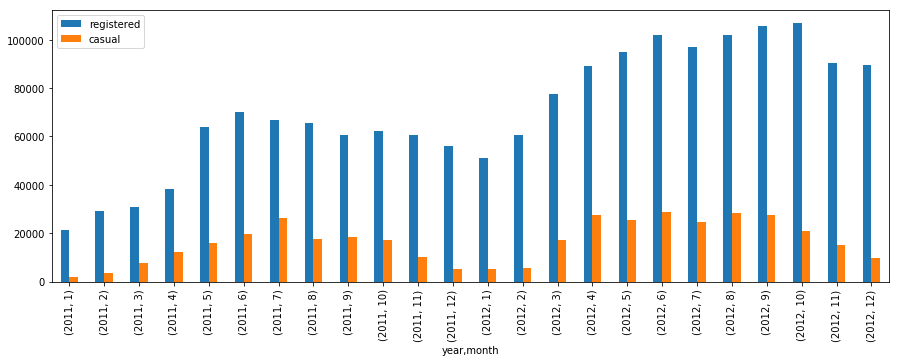

In [43]:
# Bike share demand over month - registered and casual
fulldata1.groupby(['year', 'month'])['registered','casual'].agg(sum).plot(kind='bar',figsize=(15,5),legend='true')

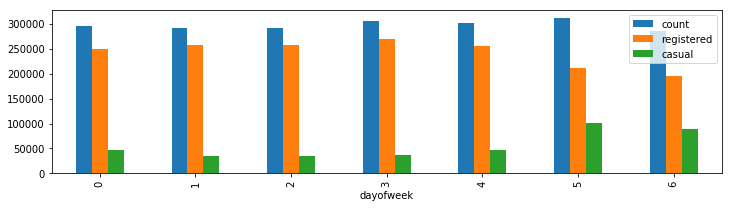

In [44]:
# Bike share demand by day of week
by_dayofweek = fulldata1.groupby('dayofweek')[['count','registered','casual']].agg(sum)
by_dayofweek.plot(kind='bar', figsize=(12,3))
# weekend and weekday use shows different patterns for registered and casual users.
#0 is Monday.

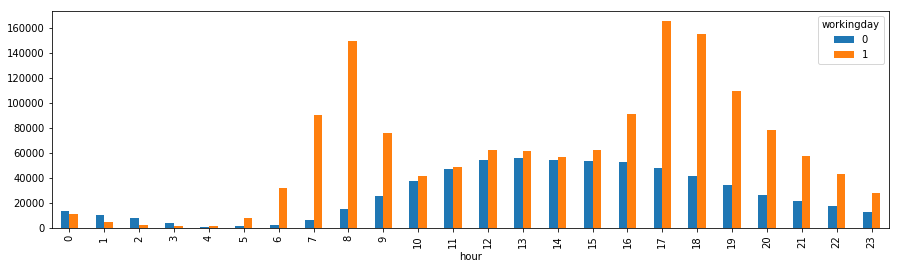

In [45]:
# Bike share demand by hour - all users, split by working day and non-working day
by_hour = fulldata1.groupby(['hour', 'workingday'])['count'].agg(sum).unstack()
by_hour.plot(kind='bar', figsize=(15,4))
#clear peak and off-peak period for working days.

#### Create a feature - peak that indicates if the hour falls into the peak period. Peak period is defined as:
- working days: 7-9 AM in the morning, 5-7 PM in the afternoon
- non-working days: 11 AM to 5 PM

In [46]:
fulldata1['peak'] = fulldata1[['hour', 'workingday']].apply(lambda x: (0, 1)[(x['workingday'] == 1 and  ( 7 <= x['hour'] <= 9 or 17 <= x['hour'] <= 19)) or (x['workingday'] == 0 and  11 <= x['hour'] <= 17)], axis = 1)

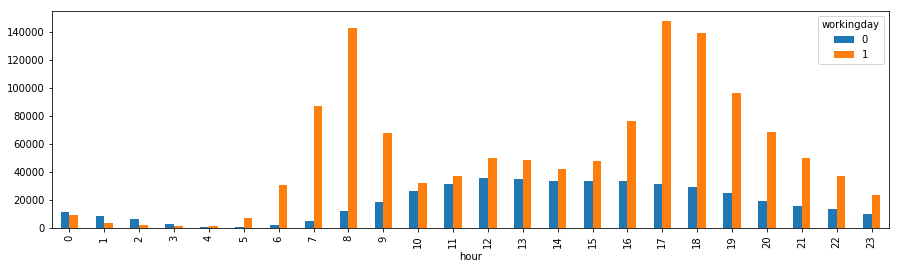

In [47]:
# Bike share demand by hour - registered users, split by working day and non-working day
by_hour = fulldata1.groupby(['hour', 'workingday'])['registered'].agg(sum).unstack()
by_hour.plot(kind='bar', figsize=(15,4))
#clear peak and off-peak period for working days.

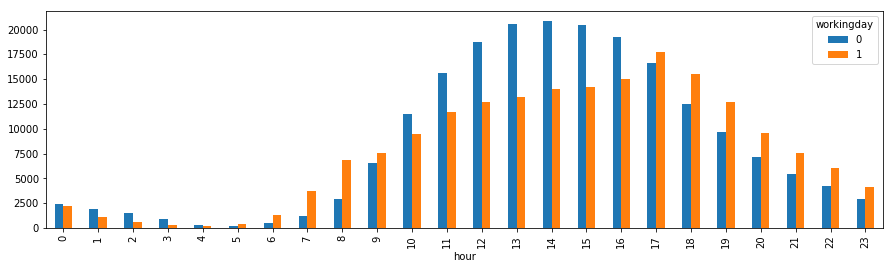

In [48]:
# Bike share demand by hour - casual users, split by working day and non-working day
by_hour = fulldata1.groupby(['hour', 'workingday'])['casual'].agg(sum).unstack()
by_hour.plot(kind='bar', figsize=(15,4))

In [49]:
fulldata1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 27 columns):
atemp             17379 non-null float64
casual            10886 non-null float64
casual_log        10886 non-null float64
count             10886 non-null float64
count_log         10886 non-null float64
datetime          17379 non-null object
holiday           17379 non-null int64
humidity          17379 non-null int64
registered        10886 non-null float64
registered_log    10886 non-null float64
season            17379 non-null object
temp              17379 non-null float64
weather           17379 non-null object
windspeed         17379 non-null float64
workingday        17379 non-null int64
year              17379 non-null int64
date_x            17379 non-null object
day               17379 non-null int64
month             17379 non-null int64
hour              17379 non-null int64
dayofweek         17379 non-null int64
weekofyr       

In [50]:
fulldata1=fulldata1.drop(['date_x'], axis=1)

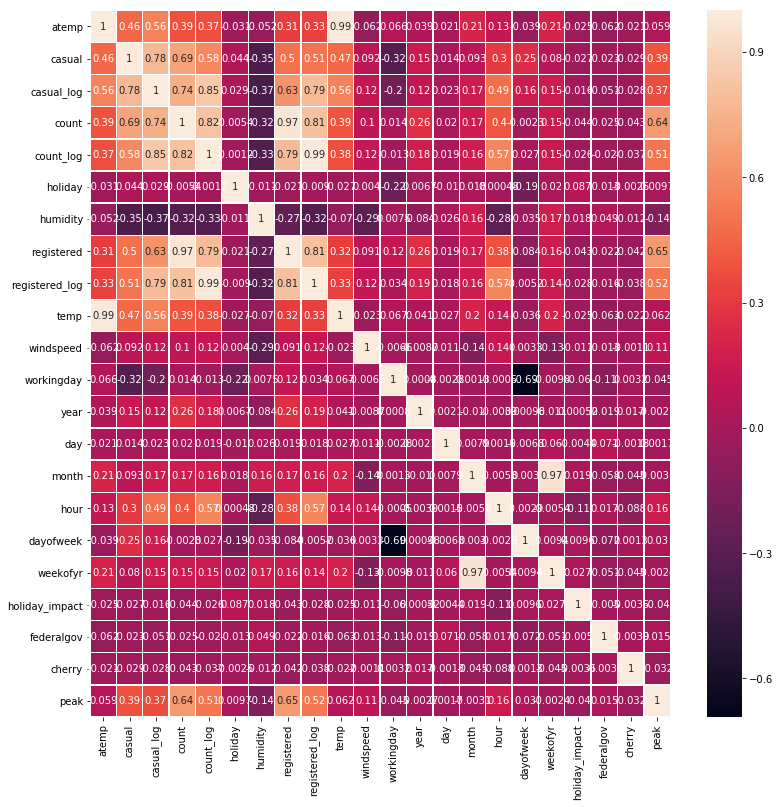

In [51]:
fig, ax = plt.subplots(figsize=(13,13))
sn.heatmap(fulldata1.corr(), annot=True,linewidths=.3)
# correlation matrix heatmap
#correlation map
#corrMat = fulldata.corr()
#mask = np.array(corrMat)
#mask[np.tril_indices_from(mask)] = False
#fig, ax= plt.subplots(figsize=(20, 10))
#sn.heatmap(corrMat, mask=mask,vmax=1., square=True,annot=True)

### Model Building

In [279]:
fulldata1.columns

Index(['atemp', 'casual', 'casual_log', 'count', 'count_log', 'datetime',
       'holiday', 'humidity', 'registered', 'registered_log', 'season', 'temp',
       'weather', 'windspeed', 'workingday', 'year', 'day', 'month', 'hour',
       'dayofweek', 'weekofyr', 'holiday_impact', 'date_y', 'federalgov',
       'cherry', 'peak'],
      dtype='object')

In [280]:
fulldata1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 26 columns):
atemp             17379 non-null float64
casual            10886 non-null float64
casual_log        10886 non-null float64
count             10886 non-null float64
count_log         10886 non-null float64
datetime          17379 non-null object
holiday           17379 non-null int64
humidity          17379 non-null int64
registered        10886 non-null float64
registered_log    10886 non-null float64
season            17379 non-null object
temp              17379 non-null float64
weather           17379 non-null object
windspeed         17379 non-null float64
workingday        17379 non-null int64
year              17379 non-null int64
day               17379 non-null int64
month             17379 non-null int64
hour              17379 non-null int64
dayofweek         17379 non-null int64
weekofyr          17379 non-null int64
holiday_impact  

In [281]:
# create season dummy
season_dummy=pd.get_dummies(fulldata1['season'])

In [282]:
# create weather dummy
weather_dummy=pd.get_dummies(fulldata1['weather'])

In [283]:
# create month dummy
month_dummy=pd.get_dummies(fulldata1['month'])

In [284]:
df_model=pd.concat([fulldata1,season_dummy,weather_dummy,month_dummy],axis=1)
df_model.columns   

Index([         'atemp',         'casual',     'casual_log',          'count',
            'count_log',       'datetime',        'holiday',       'humidity',
           'registered', 'registered_log',         'season',           'temp',
              'weather',      'windspeed',     'workingday',           'year',
                  'day',          'month',           'hour',      'dayofweek',
             'weekofyr', 'holiday_impact',         'date_y',     'federalgov',
               'cherry',           'peak',           'Fall',         'Spring',
               'Summer',         'Winter',   ' Clearcloudy', ' HeavySnowRain',
       ' LightSnowRain',    ' MistCloudy',                1,                2,
                      3,                4,                5,                6,
                      7,                8,                9,               10,
                     11,               12],
      dtype='object')

In [285]:
df_model.rename(columns={1: 'Jan', 2: 'Feb',3: 'Mar',4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Sep',10: 'Oct',11: 'Nov',12: 'Dec'}, inplace=True)


In [286]:
df_model.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
atemp,17379.0,23.788755,8.592511,0.000000,16.665000,24.240000,31.060000,50.000000
casual,10886.0,36.021955,49.960477,0.000000,4.000000,17.000000,49.000000,367.000000
casual_log,10886.0,2.712439,1.491055,0.000000,1.609438,2.890372,3.912023,5.908083
count,10886.0,191.574132,181.144454,1.000000,42.000000,145.000000,284.000000,977.000000
count_log,10886.0,4.591364,1.419454,0.693147,3.761200,4.983607,5.652489,6.885510
holiday,17379.0,0.028770,0.167165,0.000000,0.000000,0.000000,0.000000,1.000000
humidity,17379.0,62.722884,19.292983,0.000000,48.000000,63.000000,78.000000,100.000000
registered,10886.0,155.552177,151.039033,0.000000,36.000000,118.000000,222.000000,886.000000
registered_log,10886.0,4.395774,1.399383,0.000000,3.610918,4.779123,5.407172,6.787845
temp,17379.0,20.376474,7.894801,0.820000,13.940000,20.500000,27.060000,41.000000


In [287]:
df_model['season'] = df_model.season.map({"Spring": 1, "Summer": 2, "Fall":3, "Winter":4 })
#weather
df_model['weather'] = df_model.weather.map({" Clearcloudy": 1," MistCloudy":2, " LightSnowRain":3, " HeavySnowRain":4 })

In [288]:
df_model['season'] = df_model['season'].astype('category')
df_model['weather'] = df_model['weather'].astype('category')

In [289]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 46 columns):
atemp             17379 non-null float64
casual            10886 non-null float64
casual_log        10886 non-null float64
count             10886 non-null float64
count_log         10886 non-null float64
datetime          17379 non-null object
holiday           17379 non-null int64
humidity          17379 non-null int64
registered        10886 non-null float64
registered_log    10886 non-null float64
season            17379 non-null category
temp              17379 non-null float64
weather           17379 non-null category
windspeed         17379 non-null float64
workingday        17379 non-null int64
year              17379 non-null int64
day               17379 non-null int64
month             17379 non-null int64
hour              17379 non-null int64
dayofweek         17379 non-null int64
weekofyr          17379 non-null int64
holiday_impa

#### Split the train and test dataset

In [356]:
Xdf=df_model[['peak','atemp','humidity','workingday','dayofweek','weekofyr','holiday_impact','federalgov', 'hour','day','Fall', 'Spring', 'Summer', 'Winter', ' Clearcloudy',' HeavySnowRain', ' LightSnowRain', ' MistCloudy' ]].copy()
Ydf=df_model[['count_log','day']].copy()

In [357]:
X_train=Xdf[Xdf['day']<=19]
X_test=Xdf[Xdf['day']>19]

Y_train=Ydf[Ydf['day']<=19]
Y_test=Ydf[Ydf['day']>19]

In [358]:
X_train=X_train.drop(['day'], axis=1)
X_test=X_test.drop(['day'], axis=1)

Y_train=Y_train.drop(['day'], axis=1)
Y_test=Y_test.drop(['day'], axis=1)

print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 10886 samples.
Testing set has 6493 samples.


In [359]:
print(X_train.isnull().sum().sum())
print(X_test.isnull().sum().sum())

0
0


#### the data is shuffled into a random order when creating the training and testing subsets to remove any bias in the ordering of the dataset. Training/Testing subsets splitting and cross-validation are cconcepts/tools to reduce or prevent overfitting. Overfitting indicates the model fails to find good properties of training set that will generalize well to testing set. The training set is used to train or build a model. Once a model is built on training data, we need to find out the accuracy of the model on unseen data. For this, we use the testing set to provide an unbiased evaluation of the model fit on the training set. Splitting a dataset into some ratio of training and testing subssets for a learning algorithm helps to ensure a better predictive model assessment and possibly model refinement.

In [360]:
#further split training set into train and test set (original test set in Kaggle does not include target variable)
from sklearn.cross_validation import train_test_split

#Shuffle and split the data into training and testing subsets
Xdf_train, Xdf_test, Ydf_train, Ydf_test = train_test_split(X_train, Y_train, test_size=0.25, random_state=0)
print (Xdf_train.shape, Ydf_train.shape)
print (Xdf_test.shape, Ydf_test.shape)
# Success
print("Training and testing split was successful.")


(8164, 17) (8164, 1)
(2722, 17) (2722, 1)
Training and testing split was successful.


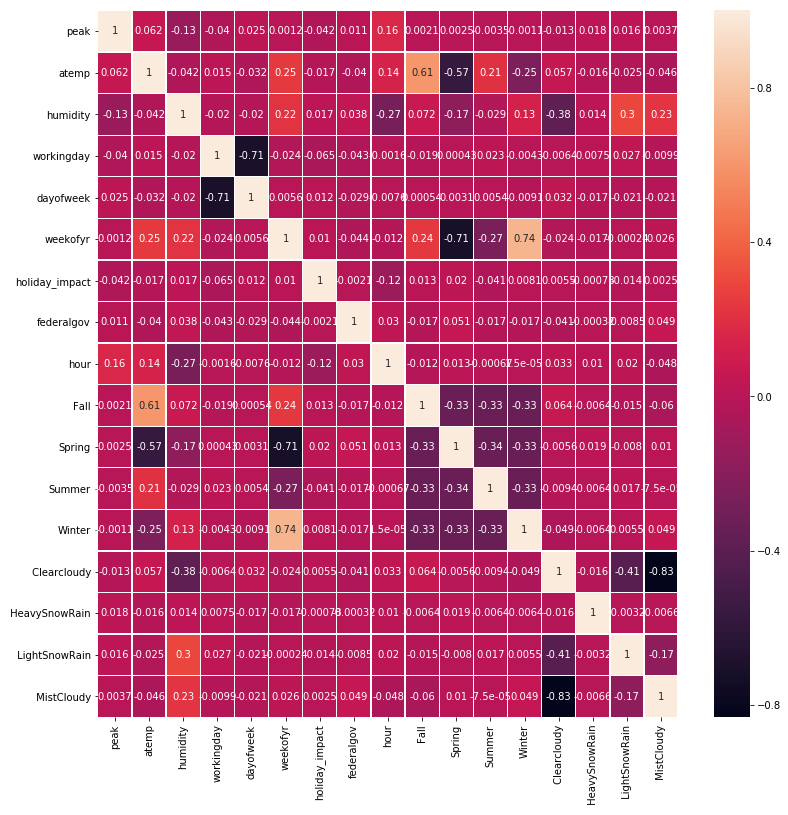

In [361]:
fig, ax = plt.subplots(figsize=(13,13))
sn.heatmap(Xdf_train.corr(), annot=True,linewidths=.3)

#### Start with the target variable = total count.

In [362]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import mean_squared_error, r2_score

In [363]:
def rmsle(y_pred, y_test) : 
    assert len(y_test) == len(y_pred)
    return np.sqrt(np.mean((np.log(1+y_pred) - np.log(1+y_test))**2))

#### Baseline: Linear Regression

#### Dummy variables in linear regression: Note that in general we have to create k-1 dummy variables if we want to analyze the effect of a categorical variable with k classes in a linear regression model. For example, there are four seasons in a year, we drop 'winter' dummy, because we pick winter as the reference.

In [364]:
Xdf_train_lin=Xdf_train.drop([' HeavySnowRain'], axis=1)
Xdf_test_lin=Xdf_test.drop([' HeavySnowRain'], axis=1)

In [216]:
#from sklearn.preprocessing import StandardScaler
#scl= StandardScaler()
#Xdf_train = scl.fit_transform(Xdf0_train)
#Xdf_test = scl.transform(Xdf0_test)

In [365]:
lreg = LinearRegression()

In [366]:
lreg.fit(Xdf_train_lin,Ydf_train)
lreg_train_pred = lreg.predict(Xdf_train_lin)
lreg_pred = lreg.predict(Xdf_test_lin)
print ("RMSLE Value For Linear Regression (train): ")
print(rmsle(Ydf_train, lreg_train_pred))
print ("RMSLE Value For Linear Regression (test): ")
print (rmsle(Ydf_test,lreg_pred))


RMSLE Value For Linear Regression (train): 
count_log    0.204274
dtype: float64
RMSLE Value For Linear Regression (test): 
count_log    0.205979
dtype: float64


#### Returns the coefficient of determination (R^2) below. R^2 = A measure of how well observed outcomes are replicated by the model, as the proportion of total variation of outcomes explained by the model.  It has a R2 score of 0.634, which implies 63.4% of variation of target variable is explained by the independent variables. 

In [367]:
print ('R2 for Linear Regression (train): %.6f' %  r2_score (Ydf_train, lreg_train_pred))
print ('R2 for Linear Regression (test): %.6f' %  r2_score (Ydf_test, lreg_pred))

R2 for Linear Regression (train): 0.633602
R2 for Linear Regression (test): 0.639185


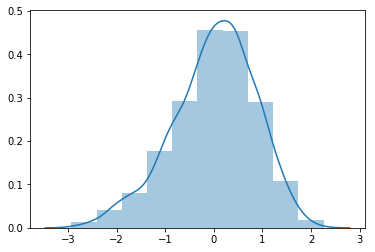

In [368]:
sn.distplot(Ydf_test-lreg_pred, bins = 10)

#### Random Forest

In [371]:
regr = RandomForestRegressor(n_jobs=-1, random_state=42, max_depth=5,n_estimators=100)

In [372]:
# Ydf pass a 2d array which happened to be in the form (X, 1), but the method expects a 1d array and has to be in the form (X, ). Convert.
Ydf_train = Ydf_train[['count_log']].values.ravel()

In [373]:
Ydf_test = Ydf_test[['count_log']].values.ravel()

In [374]:
regr.fit(Xdf_train, Ydf_train)
regr_train_pred = regr.predict(Xdf_train)
#regr_pred = np.expm1(regr.predict(Xdf_test.values))
regr_pred = regr.predict(Xdf_test)
print ("RMSLE Value For RF Regression (train): ")
print(rmsle(Ydf_train, regr_train_pred))
print ("RMSLE Value For RF Regression (test): ")
print(rmsle(Ydf_test,regr_pred))

RMSLE Value For RF Regression (train): 
0.120837128597
RMSLE Value For RF Regression (test): 
0.128173251621


In [375]:
print ('R2 for RF Regression (train): %.6f' %  r2_score (Ydf_train, regr_train_pred))
print ('R2 for RF Regression (test): %.6f' %  r2_score (Ydf_test, regr_pred))

R2 for RF Regression (train): 0.869261
R2 for RF Regression (test): 0.860255


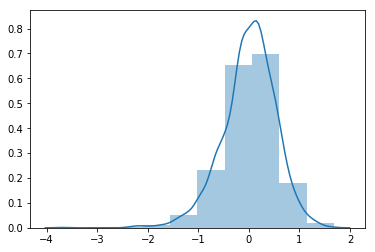

In [310]:
sn.distplot(Ydf_test-regr_pred, bins = 10)

Validation error:  [ 0.3179759   0.26863145  0.26971627]


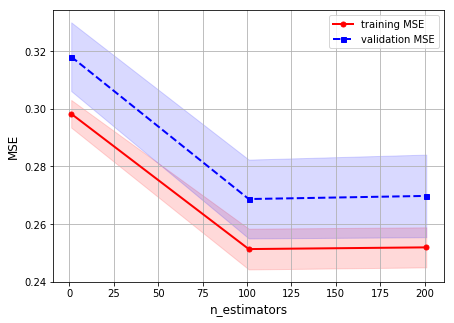

In [308]:
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
scorer=make_scorer(mean_squared_error)

from sklearn.model_selection import validation_curve
param_range =range(1,300,100)
train_error, validation_error = validation_curve(estimator=regr, X=Xdf_train, y=Ydf_train, param_name='n_estimators', param_range=param_range, cv=5, scoring=scorer, n_jobs=-1)
train_mean=np.mean(train_error,axis=1)
train_std=np.std(train_error,axis=1)
validation_mean=np.mean(validation_error,axis=1)
validation_std=np.std(validation_error,axis=1)
plt.figure(figsize=(7,5))
plt.plot(param_range,train_mean,color='red', marker='o', markersize=5,lw=2,label='training MSE')
plt.fill_between(param_range,train_mean+train_std,train_mean-train_std,alpha=.15,color='r')
plt.plot(param_range,validation_mean, color='b',linestyle='--',marker='s',markersize=5,lw=2, label='validation MSE')
plt.fill_between(param_range,validation_mean+validation_std,validation_mean-validation_std,alpha=.15,color='b')
plt.grid()
plt.legend(loc='upper right')
plt.xlabel('n_estimators',fontsize=12)
plt.ylabel('MSE',fontsize=12)
print ("Validation error: ", validation_mean)

#### Grid search is conducted to tune all parameters automatically and find the best combination. 

In [311]:
# Grid search
import time
start_time=time.time()

max_depth_arr=range(5,20)
n_estimator_arr=range(40,200,20)
param_grid=[{'max_depth':max_depth_arr,'n_estimators':n_estimator_arr}]

gs=GridSearchCV(estimator=regr,param_grid=param_grid,scoring="neg_mean_squared_error",cv=5,n_jobs=-1)

gs.fit(Xdf_train, Ydf_train)

print("process time total:{:.2f} seconds".format(time.time()-start_time))

process time total:214.96 seconds


In [312]:
print("best score: %s" % gs.best_score_)
print("best param: %s" % gs.best_params_)

best score: -0.148138921594
best param: {'max_depth': 19, 'n_estimators': 180}


#### Re-run the model using the optimized parameters.

In [376]:
num_estimators = 180
max_depth= 19

forest= RandomForestRegressor(n_estimators=num_estimators,max_depth=max_depth,random_state=42, n_jobs=-1)

forest.fit(Xdf_train, Ydf_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=19,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=180, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [377]:
forest.fit(Xdf_train, Ydf_train)
forest_train_pred = forest.predict(Xdf_train)
#forest_pred = np.expm1(forest.predict(Xdf_test.values))
forest_pred = forest.predict(Xdf_test)
print ("RMSLE Value For Random Forest Regression (optimized, train): ")
print(rmsle(Ydf_train, forest_train_pred))
print ("RMSLE Value For Random Forest Regression (optimized, test): ")
print(rmsle(Ydf_test, forest_pred))

RMSLE Value For Random Forest Regression (optimized, train): 
0.0368824899507
RMSLE Value For Random Forest Regression (optimized, test): 
0.0961707131928


In [378]:
print ('R2 for RF Regression (optimized,train): %.6f' %  r2_score (Ydf_train, forest_train_pred))
print ('R2 for RF Regression (optimized,test): %.6f' %  r2_score (Ydf_test, forest_pred))

R2 for RF Regression (optimized,train): 0.989323
R2 for RF Regression (optimized,test): 0.928751


#### Feature importance is listed below. 

In [379]:
features=list(Xdf_train.columns)
importances = forest.feature_importances_

indices=np.argsort(importances)[::-1]
for f in range(Xdf_train.shape[1]):
    print ("%2d) %-*s %f" % (f+1, 30, features[indices[f]],importances[indices[f]]))

 1) hour                           0.715412
 2) atemp                          0.061398
 3) peak                           0.058772
 4) weekofyr                       0.041586
 5) humidity                       0.036502
 6) workingday                     0.035833
 7) dayofweek                      0.019392
 8) Spring                         0.009427
 9)  LightSnowRain                 0.008648
10) Winter                         0.006856
11)  Clearcloudy                   0.002052
12)  MistCloudy                    0.001601
13) Fall                           0.001533
14) Summer                         0.000773
15) federalgov                     0.000120
16) holiday_impact                 0.000095
17)  HeavySnowRain                 0.000000


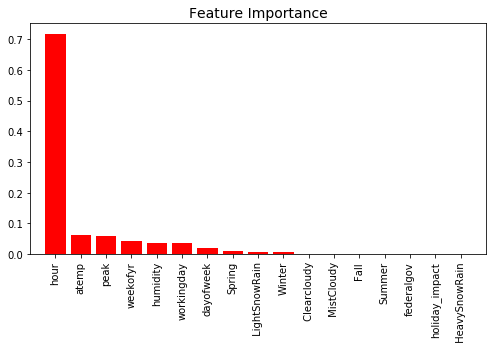

In [380]:
plt.figure(figsize=(7,5))
plt.title('Feature Importance', fontsize=14)
plt.bar(range(Xdf_train.shape[1]), importances[indices],color='red', align='center')
plt.xticks(range(Xdf_train.shape[1]), Xdf_train[features].columns[indices],rotation=90)
plt.xlim([-1,Xdf_train.shape[1]])
plt.tight_layout()

#### Gradient Boost

In [381]:
gbr = GradientBoostingRegressor(learning_rate=0.05, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=200, random_state=42)

In [383]:
gbr.fit(Xdf_train,Ydf_train)
gbr_train_pred = gbr.predict(Xdf_train)
gbr_pred = gbr.predict(Xdf_test)
print ("RMSLE Value For Gadient Boost Regression(train): ")
print(rmsle(Ydf_train, gbr_train_pred))
print ("RMSLE Value For Gadient Boost Regression (test): ")
print(rmsle(Ydf_test, gbr_pred))

RMSLE Value For Gadient Boost Regression(train): 
0.0790740166091
RMSLE Value For Gadient Boost Regression (test): 
0.0930892753387


In [384]:
print ('R2 for GB Regression (optimized,train): %.6f' %  r2_score (Ydf_train, gbr_train_pred))
print ('R2 for GB Regression (optimized,test): %.6f' %  r2_score (Ydf_test, gbr_pred))

R2 for GB Regression (optimized,train): 0.946109
R2 for GB Regression (optimized,test): 0.930398


In [ ]:
#grid search
#scorer = make_scorer(rmsle, greater_is_better=False)

#n_estimator_arr=range(1000,4000,1000)
#learning_rate_arr=[0.01,0.05,0.1]
#max_depth_arr=range(4,10)
#param_grid=[{'max_depth':max_depth_arr,'n_estimators':n_estimator_arr, 'learning_rate':learning_rate_arr}]

#gs=GridSearchCV(estimator=gbr,param_grid=param_grid,scoring=scorer,cv=5,n_jobs=-1)
#gs.fit(Xdf_train, Ydf_train)
## It took too long to run the grid search due to the limit of computational power. The code is listed above though.

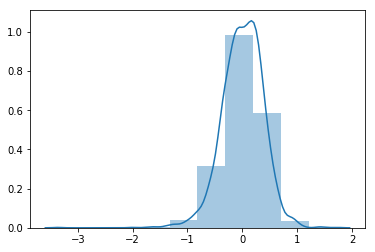

In [395]:
sn.distplot(Ydf_test-gbr_pred, bins = 10)

#### Adaboosting

#### note that SVM is not fully implemented due to the limit of time. Code is listed below.

In [ ]:
#svm = SVR(C=1, cache_size=200, coef0=0, degree=3, epsilon=0.1, gamma='auto',
 # kernel='poly', max_iter=-1, shrinking=True, tol=0.001)

In [ ]:
#svm.fit(Xdf_train, Ydf_train)
#svm_train_pred = svm.predict(Xdf_train)
#svm_pred = np.expm1(svm.predict(Xdf_test.values))

#print ("RMSLE Value For SVM: ")
#print(rmsle(Ydf_train, svm_train_pred))

In [385]:
ada_tree = DecisionTreeRegressor(max_features='sqrt', max_depth=3)
ab= AdaBoostRegressor(ada_tree, learning_rate=0.1, loss='square', n_estimators=1000)

In [387]:
ab.fit(Xdf_train, Ydf_train)
ab_train_pred = ab.predict(Xdf_train)
ab_pred = ab.predict(Xdf_test)

print ("RMSLE Value For Adaboosting (train): ")
print(rmsle(Ydf_train, ab_train_pred))
print ("RMSLE Value For Adaboosting (test): ")
print(rmsle(Ydf_test, ab_pred))

RMSLE Value For Adaboosting (train): 
0.166377103523
RMSLE Value For Adaboosting (test): 
0.171543779371


In [393]:
print ('R2 for AB Regression (train): %.6f' %  r2_score (Ydf_train, ab_train_pred))
print ('R2 for AB Regression (test): %.6f' %  r2_score (Ydf_test, ab_pred))

R2 for AB Regression (train): 0.735782
R2 for AB Regression (test): 0.730068


### Make Ensemble Prediction, Stacking Models

In [388]:
forest_train_pred1=pd.DataFrame(forest_train_pred)
forest_test_pred1=pd.DataFrame(forest_pred)

gbr_train_pred1=pd.DataFrame(gbr_train_pred)
gbr_test_pred1=pd.DataFrame(gbr_pred)

In [389]:
df = pd.concat([forest_train_pred1, gbr_train_pred1], axis=1)
df_test = pd.concat([forest_test_pred1, gbr_test_pred1], axis=1)

In [391]:
ensemble = LinearRegression()
ensemble.fit(X = df,y = Ydf_train)

ensemble_train_pred = ensemble.predict(df)
ensemble_pred = ensemble.predict(df_test)
print ("RMSLE Value For Linear Regression (Ensemble, train): ")
print(rmsle(Ydf_train, ensemble_train_pred))
print ("RMSLE Value For Linear Regression (Ensemble, test): ")
print(rmsle(Ydf_test, ensemble_pred))

RMSLE Value For Linear Regression (Ensemble, train): 
0.0271388180077
RMSLE Value For Linear Regression (Ensemble, test): 
0.102222284245


In [394]:
print ('R2 for Ensemble Regression (train): %.6f' %  r2_score (Ydf_train, ensemble_train_pred))
print ('R2 for Ensemble Regression (test): %.6f' %  r2_score (Ydf_test, ensemble_pred))

R2 for Ensemble Regression (train): 0.993892
R2 for Ensemble Regression (test): 0.918893
